In [1]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import uproot
from pathlib import Path

In [2]:
#Defining constants and variables 

c = 299.792458 #mm.ns^-1
timeRes = 0.4 #ns
TOFsigma = (c*timeRes)/(2*np.sqrt(2*np.log(2)) * 2) # convert FWHM to sigma. Extra 2 is because we are dealing with time diff, not total time
voxSize = 2 #mm (2mm cube)

#creating 150 steps in x and y direc, and 16 steps in z direc
voxGrid = np.zeros((int(300/voxSize),int(300/voxSize),int(32/voxSize))) #grid of voxels
voxGridSimp = np.zeros((int(300/voxSize), int(300/voxSize),int(32/voxSize))) #grid of voxels
voxDim = voxGrid.shape #(150, 150, 16)
voxGridOrigin = np.array((-voxDim[0]+1, -voxDim[1]+1, -voxDim[2]+1)) # bottom left back corner
timeThresh = 0.7 # chose this because it should be the max time difference if a decay occurs at the circumference of the r = 100mm circle
#ensures only physically plausible pairs are considered

In [3]:
def getSinogramVals(X, Y):

    if X[1] == X[0] and Y[1] == Y[0]: #same point, invalid LOR
        return 999,0
    
    elif X[1] == X[0]: #vertical line
        return abs(X[0]), np.pi/2
    
    elif Y[1] == Y[0]: #horizontal line
        return abs(Y[0]), 0
    
    else:
        m = (Y[1]-Y[0]) / (X[1] - X[0]) #gradient
        c = Y[0] - m*X[0] # y-int
        xInt = m*(m*X[0]-Y[0])/(m**2+1) #x of perp projection to origin
        yInt = m*xInt+c #corresp y
        R = np.sqrt(xInt**2+yInt**2) #distance from origin to line
        theta = np.arctan(m) #angle of LOR
        return R, theta
    

In [4]:
#Function to update the 3D voxel grid based on where a positron annihilation (or decay) event likely occured
def fillVoxel(DT,p1,p2): 

    ''' DT is the time difference between the two detected photons (ns)
        p1 and p2 are the 3D positions of the two gamma hits (mm)
        
        This function estimates the position where the annihlation likely occurs
        Adds a weighted "smear along the LOR using TOF information
        Also stores a simple midpoint estimate separately, without TOF weighting'''
    
    midPoint = (p2+p1)/2 # midpoint between detection points

    voxIndsSimp = np.floor(midPoint/2 - voxGridOrigin/2).astype(int) # converts the midpoint to a voxel grid index
    voxGridSimp[tuple(voxIndsSimp)] += 1

    p2_p1 = p2-p1 # vector of LoR
    if np.all(p2_p1 != 0):
        p2_p1 = p2_p1 / np.sqrt(p2_p1[0]**2 + p2_p1[1]**2 +p2_p1[2]**2) # unit vector of LoR

    TOFpoint = midPoint - p2_p1 * (DT/2) * c # position of where decay occured due to ToF

    distances = np.linspace(-3, 3, 150) # should be 3*TOFsigma, but TOFsigma gets divided out in the following by (distance/TOFsigma), so not included. 
    weights = np.exp(-0.5 * distances**2) #weights due to ToF gaussian
    weights /= weights.sum()  # normalise
    
    for d, w in zip(distances, weights):
        sample_point = TOFpoint + d * p2_p1 
        voxInds = np.floor(sample_point/2 - voxGridOrigin/2).astype(int) # get voxGrid indeces of where this "decay" occured
        if np.all((voxInds >= 0) & (voxInds < voxDim)):
            voxGrid[tuple(voxInds)] += w # add weight to the frid

In [5]:
def plotHeatmap(gridMat,plotName):
    plt.imshow(gridMat, aspect='auto', cmap='hot', origin='lower', extent=[-150,150,-150,150])
    plt.colorbar(label='Counts')
    plt.xlabel('X bin')
    plt.ylabel('Y bin')
    plt.title('2D Histogram')
    
    plt.savefig("reco_heatmap_"+plotName+".png")
    plt.close()

In [6]:
# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / 'output'
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

#Loading the ROOT file
filename = os.path.join(folder, "output_vereos.root")
f = uproot.open(filename)
#print(f.keys())

singles_tree = f["Singles1"]
#print(singles_tree.keys())

branches = [
    "PostPosition_X",
    "PostPosition_Y",
    "PostPosition_Z",
    "GlobalTime",
    "LocalTime",
    "TotalEnergyDeposit"
]

df = singles_tree.arrays(branches, library="pd")

print("sorting")
# Sort by the 'time' variable
df_sorted = df.sort_values(by="GlobalTime")

print("Making numpy arrays")
# Convert a specific branch to a NumPy array (e.g., for the variable "energy")
x_array = df_sorted["PostPosition_X"].to_numpy() #in mm
y_array = df_sorted["PostPosition_Y"].to_numpy() #in mm
z_array = df_sorted["PostPosition_Z"].to_numpy() #in mm
time = df_sorted["GlobalTime"].to_numpy()  #in nanoseconds
Loc_time = df_sorted["LocalTime"].to_numpy()  #in nanoseconds
energy = df_sorted["TotalEnergyDeposit"].to_numpy() # in MeV
phi_array = np.arctan2(y_array,x_array) #angle around PET-axis in rads. 0 to pi if in first 2 quadrants, 0 to -pi if in other quadrants


The Current Working Directory (CWD) is /Users/jemmabagg/Documents/Masters/picoPET-sim
The output folder is /Users/jemmabagg/Documents/Masters/picoPET-sim/output
sorting
Making numpy arrays


0.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jemmabagg/Library/Python/3.11/lib/python/site-packages/IPython/c

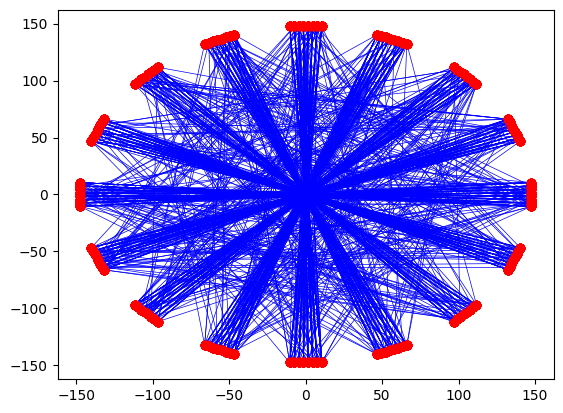

In [7]:
r_vals = []
theta_vals = []

numPairs = 0
N = len(time)-1
#N = 300000
prog = int(N/10)
i=0
while i < N:
    if i%prog==0:
        print(100*i/N)
    DT = time[i+1]-time[i]
    r,theta = getSinogramVals([x_array[i],x_array[i+1]], [y_array[i],y_array[i+1]])

    if DT<timeThresh: # make sure incident photons are within a time window
        if r < 100: # assuming average size of a human head, there should be no decays outside this radius
            numPairs+=1
            # just a plot of the lines of response
            if numPairs < 1000:
                plt.plot([x_array[i],x_array[i+1]], [y_array[i],y_array[i+1]], "-b", linewidth=0.5)
                plt.plot(x_array[i],y_array[i],"or")
                plt.plot(x_array[i+1],y_array[i+1],"or")
            r_vals.append(r)
            theta_vals.append(theta)
            p2 = np.array([x_array[i+1],y_array[i+1],z_array[i+1]])
            p1 = np.array([x_array[i],y_array[i],z_array[i]])
            fillVoxel(DT,p1,p2)

            
        i+=1
    i+=1


'# Save sinogram plot\nplt.savefig("reco_sinogram_" + suffix + ".png")\nplt.close()'

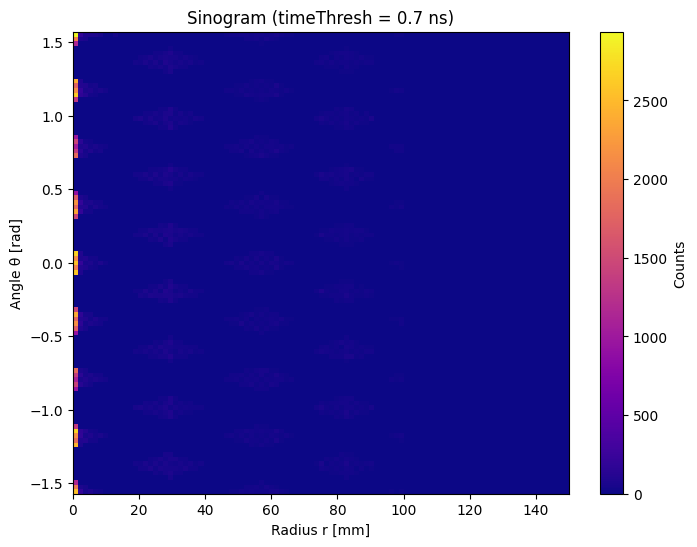

In [8]:
# Create 2D histogram for sinogram
r_bins = np.linspace(0, 150, 100)  # Radius bins
theta_bins = np.linspace(-np.pi / 2, np.pi / 2, 100)  # Angle bins

# Create the 2D histogram of r, θ
H, r_edges, theta_edges = np.histogram2d(r_vals, theta_vals, bins=[r_bins, theta_bins])

# Plot the sinogram
plt.figure(figsize=(8, 6))
plt.imshow(
    H.T,  # Transpose so theta is the vertical axis
    extent=[r_bins[0], r_bins[-1], theta_bins[0], theta_bins[-1]],
    aspect='auto',
    origin='lower',  # Ensures the origin (0, 0) is at the bottom-left
    cmap='plasma'  # Can change to 'hot', 'inferno', etc.
)

plt.colorbar(label='Counts')
plt.xlabel('Radius r [mm]')
plt.ylabel('Angle θ [rad]')
plt.title(f"Sinogram (timeThresh = {timeThresh} ns)")

'''# Save sinogram plot
plt.savefig("reco_sinogram_" + suffix + ".png")
plt.close()'''

'# Save heatmap plot\nplt.savefig("reco_heatmap_" + suffix + ".png")\nplt.close()'

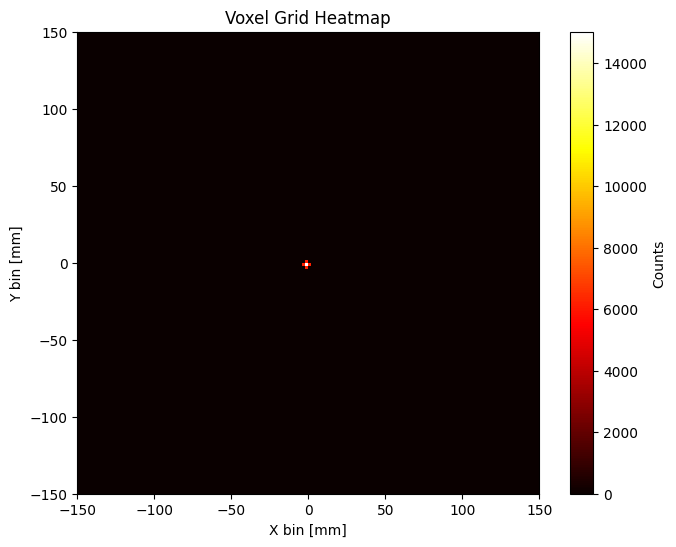

In [9]:
# Sum over the z-axis to reduce to 2D (X-Y plane)
voxGrid2D = np.sum(voxGrid, axis=2).T  # Transpose to get correct orientation

# Apply a threshold to reduce noise (optional)
threshold = 0.33 * np.max(voxGrid2D)  # Take the top 33% of the values
voxGrid2D_reduced = np.zeros_like(voxGrid2D)
voxGrid2D_reduced[voxGrid2D > threshold] = voxGrid2D[voxGrid2D > threshold]

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    voxGrid2D_reduced,  # This will plot the reduced voxel grid
    cmap='hot',  # Change to 'plasma', 'inferno', etc., if you prefer
    origin='lower',  # Ensure the origin is at the bottom-left
    extent=[-150, 150, -150, 150]  # Set axes to represent real-world dimensions (in mm)
)

plt.colorbar(label='Counts')
plt.xlabel('X bin [mm]')
plt.ylabel('Y bin [mm]')
plt.title(f"Voxel Grid Heatmap")

'''# Save heatmap plot
plt.savefig("reco_heatmap_" + suffix + ".png")
plt.close()'''